In [1]:
!pip install praw pandas seaborn scipy

In [2]:
import csv
from datetime import datetime
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import praw
import prawcore
import random
import seaborn as sns
from typing import Callable

from util import *
import validate

sns.set_theme()

In [3]:
import logging

# This will log everything
LOG = True
if LOG:
    handler = logging.StreamHandler()
    handler.setLevel(logging.WARN)
    for logger_name in ("praw", "prawcore"):
        logger = logging.getLogger(logger_name)
        logger.setLevel(logging.DEBUG)
        logger.addHandler(handler)

In [4]:
# Create the Reddit instance to do all the API stuff with
reddit = init_reddit()

In [5]:
keywords = [
    "trauma",
    "gaslight",
    "trigger",
    "toxic",
    "woke",
    "manipulat",
    "microaggression",
    "autis",
    "adhd",
    "ocd",
    "ptsd",
    "bipolar",
    "anxiety",
    "depress",
    "psycho",
    "delusion",
    "delulu",
    "solulu",
    "addict",
    "abus",
    "unstable",
    "narcissis",
    "addict",
    "neurodivergen",
]

In [6]:
first_id = int("c000000", 36)  # todo find the ID of the first post we want to analyze
# Earliest post I can find: https://www.reddit.com/api/info.json?id=t1_c015001
last_id = int("l000000", 36)  # todo find the ID of the last post we want to analyze

## Load comments

In [7]:
runs = get_runs()
missing_runs = validate.missing_runs(runs.keys())
assert len(missing_runs) == 0, missing_runs

In [8]:
df = load_comments(*runs.values())
df

,id,time,sr_name,author_id,parent_fullname,post_id,upvotes,downvotes,body
0,26151673552,2009-12-31 19:34:47,AskReddit,3qsub,t1_c0i12mx,t3_ake21,1,0,15th
1,26151680417,2009-12-31 21:46:41,TwoXChromosomes,NaN,t3_akctl,t3_akctl,8,0,I used to hate it. They I realized that my pro...
2,26151683711,2009-12-31 23:03:50,books,NaN,t3_akexp,t3_akexp,16,0,"I've never heard of Ellroy, but the fact that ..."
3,26151685221,2009-12-31 23:41:48,AskReddit,NaN,t1_c0i1cz0,t3_akerr,-5,0,The cake is a lie...
4,26151694942,2010-01-01 03:52:38,IAmA,3oypp,t1_c0i1km5,t3_ak6bq,1,0,"In case you haven't noticed, being male anywhe..."
...,...,...,...,...,...,...,...,...,...
20082,32819689542,2019-10-06 12:07:06,BoomBeach,NaN,t1_f2rzb3u,t3_ddjei6,2,0,Just irritating that our task force owner work...
20083,32822239511,2019-10-06 17:03:06,Cardinals,6vl9o55,t3_de6zzz,t3_de6zzz,9,0,At least he took 3 more pitches than DeJong...
20084,32822995485,2019-10-06 19:02:48,nfl,15gqsb,t1_f2txorq,t3_de8elz,2,0,"If ya'll shame the Pats, I'm cool with a Gulf ..."
20085,32824085316,2019-10-06 23:52:16,nfl,15l21j,t1_f2uldv8,t3_debhfs,1,0,"After the last season of Mahomes? Yeah, it is ..."


In [9]:
misses = load_misses(*runs.values())
misses

465     26151679941
256     26151764645
376     26151796128
402     26151809713
1843    26151847380
           ...     
3593    32812940464
3591    32817744019
3604    32818602318
3609    32820092297
3608    32820776324
Length: 3613, dtype: int64

In [10]:
# Sanity checks
validate.validate(df, misses)

✅ Found no duplicate comment IDs
✅ Found no duplicate misses
✅ Found no out-of-order IDs
Everything good


In [35]:
# The first ID we actually collected
first_id_actual = df[ID].min()
first_id_actual, to_b36(first_id_actual)

(26151673552, 'c0i14gg')

#### Actual analysis

In [12]:
def matches(body, keywords=keywords):
    for keyword in keywords:
        if keyword in body:
            return True
    return False

In [13]:
df[BODY] = df[BODY].map(lambda body: body.lower().strip())
matched_rows = df[df[BODY].map(matches)]
matched_rows

,id,time,sr_name,author_id,parent_fullname,post_id,upvotes,downvotes,body
1,26151680417,2009-12-31 21:46:41,TwoXChromosomes,NaN,t3_akctl,t3_akctl,8,0,i used to hate it. they i realized that my pro...
11,26151758649,2010-01-02 02:29:59,AskReddit,NaN,t3_akk1l,t3_akk1l,1,0,sterilize people from socioeconomic and financ...
103,26152214173,2010-01-07 05:44:51,atheism,NaN,t1_c0icp48,t3_amksn,14,0,"no, it wasn't. it's inexcusable to be hostile ..."
124,26152358082,2010-01-08 14:40:34,AskReddit,3lvdk,t3_an5ru,t3_an5ru,15,0,i've woken up to it a few times - middle-of-th...
167,26152673794,2010-01-12 02:12:53,AskReddit,3qeld,t1_c0imiej,t3_aocvm,2,0,i love gesture recognition. if you could hook ...
...,...,...,...,...,...,...,...,...,...
19691,32777487381,2019-09-30 22:45:23,BigBrother,ehk9zo9,t1_f1zq07l,t3_db8cld,4,0,yeah i predicted theyd get christie out way so...
19696,32777510941,2019-09-30 22:51:23,funny,2tkze9ct,t3_dblxw1,t3_dblxw1,5,0,"*""obesity often leads to depression...""*"
19713,32777595744,2019-09-30 23:13:28,microgrowery,NaN,t1_f22w6uf,t3_dblrt8,2,0,you're so right. i've been thinking about this...
19766,32777903797,2019-10-01 00:51:46,abusiverelationships,45nblm7a,t3_dbhldc,t3_dbhldc,3,0,"put downs are not normal or healthy, they're j..."


In [14]:
{
    keyword: len(matched_rows[matched_rows[BODY].map(lambda body: keyword in body)])
    for keyword in keywords
}

{'trauma': 3,
 'gaslight': 2,
 'trigger': 42,
 'toxic': 19,
 'woke': 21,
 'manipulat': 13,
 'microaggression': 0,
 'autis': 8,
 'adhd': 10,
 'ocd': 2,
 'ptsd': 4,
 'bipolar': 3,
 'anxiety': 19,
 'depress': 46,
 'psycho': 35,
 'delusion': 14,
 'delulu': 0,
 'solulu': 0,
 'addict': 23,
 'abus': 46,
 'unstable': 3,
 'narcissis': 1,
 'neurodivergen': 0}

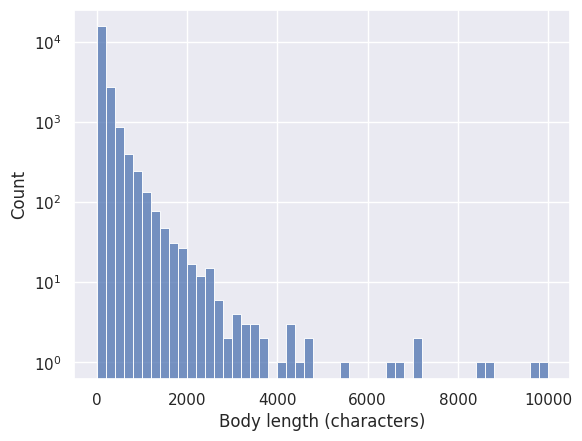

In [34]:
lengths = df[BODY].map(len)
ax = sns.histplot(
    lengths, # lengths[lengths <= 10000],
    binwidth=200,
    # log_scale=True
)
ax.set(xlabel = "Body length (characters)")
ax.set(yscale = "log");

In [16]:
df[lengths >= 10000]

,id,time,sr_name,author_id,parent_fullname,post_id,upvotes,downvotes,body


### Graphing distribution over time

<Axes: xlabel='time', ylabel='Count'>

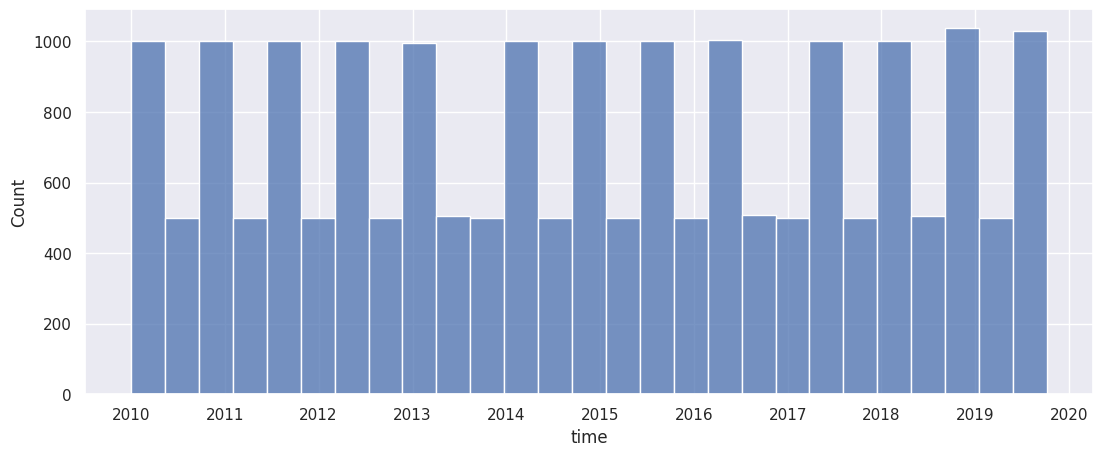

In [17]:
from datetime import timedelta

plt.figure(figsize=(13, 5))
# TODO figure out how to get binwidth to work with timedeltas
sns.histplot(data=df, x=TIME) #, binwidth=timedelta(days=30))

<Axes: xlabel='time', ylabel='Count'>

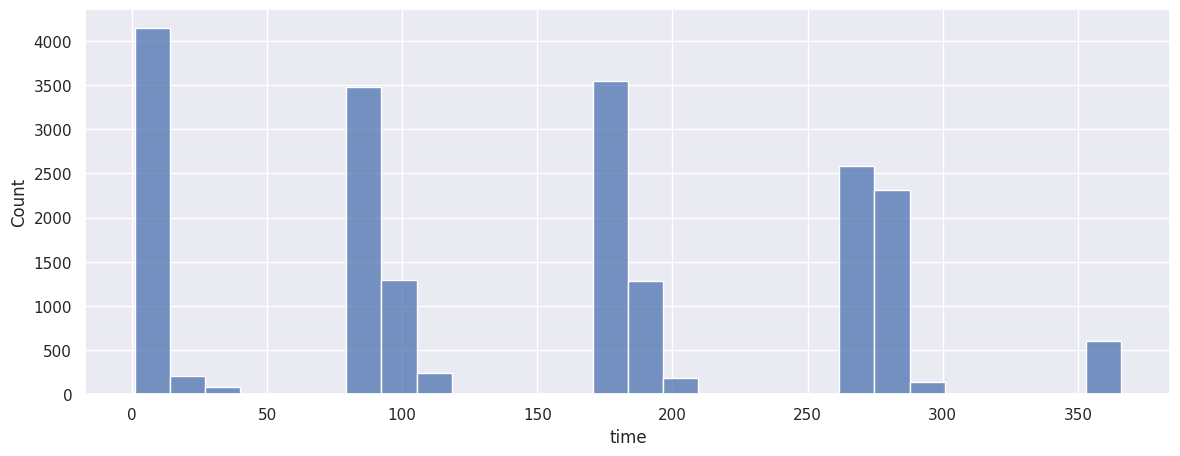

In [18]:
# Number of comments by day of year
plt.figure(figsize=(14, 5))
sns.histplot(data=df[TIME].apply(lambda t: int(t.strftime("%j"))))

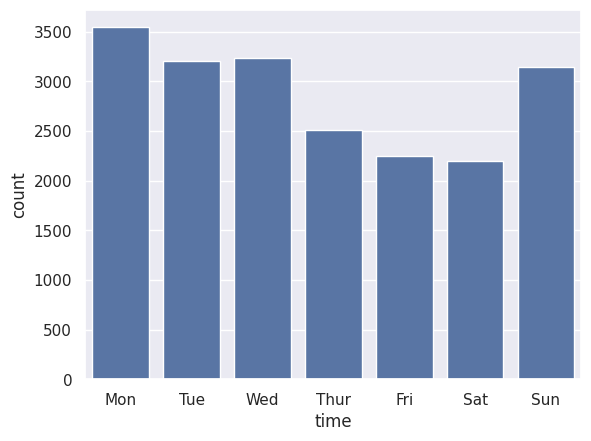

In [19]:
# Number of comments by day of week (0 = Monday)
g = sns.barplot(data=df[TIME].apply(lambda t: t.weekday()).value_counts())
g.set_xticks(
    g.get_xticks(),
    labels=[
        ["Mon", "Tue", "Wed", "Thur", "Fri", "Sat", "Sun"][tick]
        for tick in g.get_xticks()
    ],
);

### Are the IDs uniformly distributed?

Figure out if the IDs are uniformly distributed using the Kolmogorov-Smirnov test

TODO check if KS is the right test to use here. Alternatives (not sure if any of these are even applicable):
- Chi-square (we don't have a normal distribution though)
- Mann-Whitney U test
- Anderson-Darling

The fact that we're taking the first gotten comment as the start rather than the actual requested
start ID might screw things up but whatever

<Axes: xlabel='id', ylabel='Count'>

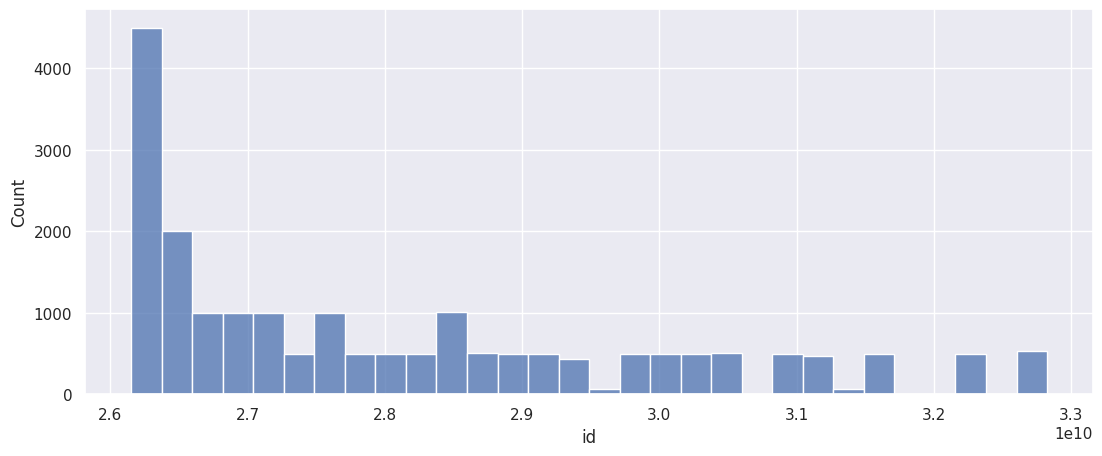

In [20]:
# Distribution of IDs

plt.figure(figsize=(13, 5))
sns.histplot(data=df[ID])

In [21]:
from scipy import stats

# Choose alpha of 0.05

ids_normalized = df[ID].map(lambda id: (id - first_id_actual) / (last_id - first_id_actual))
res = stats.ks_1samp(ids_normalized, stats.uniform.cdf)
if res.pvalue < 0.05:
    print("IDs are probably not uniformly distributed")
else:
    print("IDs are probably uniformly distributed")
res

IDs are probably not uniformly distributed


KstestResult(statistic=0.6659857052333975, pvalue=0.0, statistic_location=0.2827373494786053, statistic_sign=1)

In [22]:
# The earliest comment we have
df[df[ID] == df[ID].min()]

,id,time,sr_name,author_id,parent_fullname,post_id,upvotes,downvotes,body
0,26151673552,2009-12-31 19:34:47,AskReddit,3qsub,t1_c0i12mx,t3_ake21,1,0,15th


<Axes: >

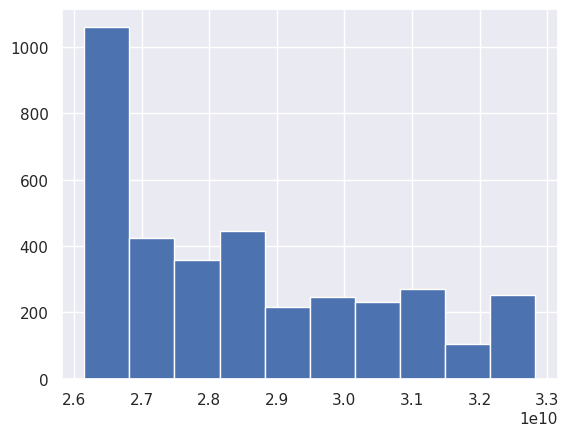

In [23]:
misses.hist()

<Axes: ylabel='Count'>

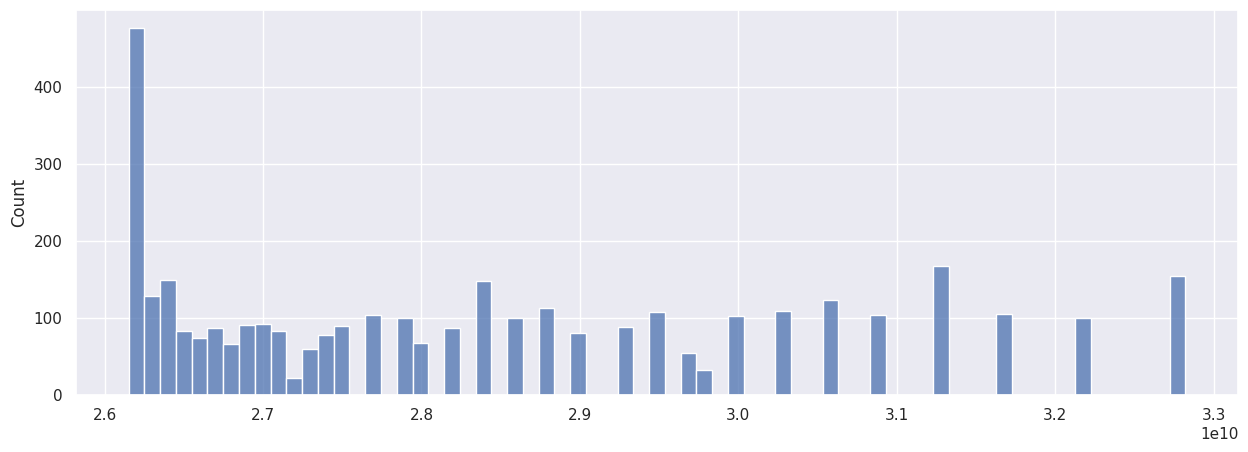

In [24]:
plt.figure(figsize=(15, 5))
misses_actual = misses[misses >= first_id_actual]
sns.histplot(misses_actual, binwidth=1e8)

<Axes: ylabel='Count'>

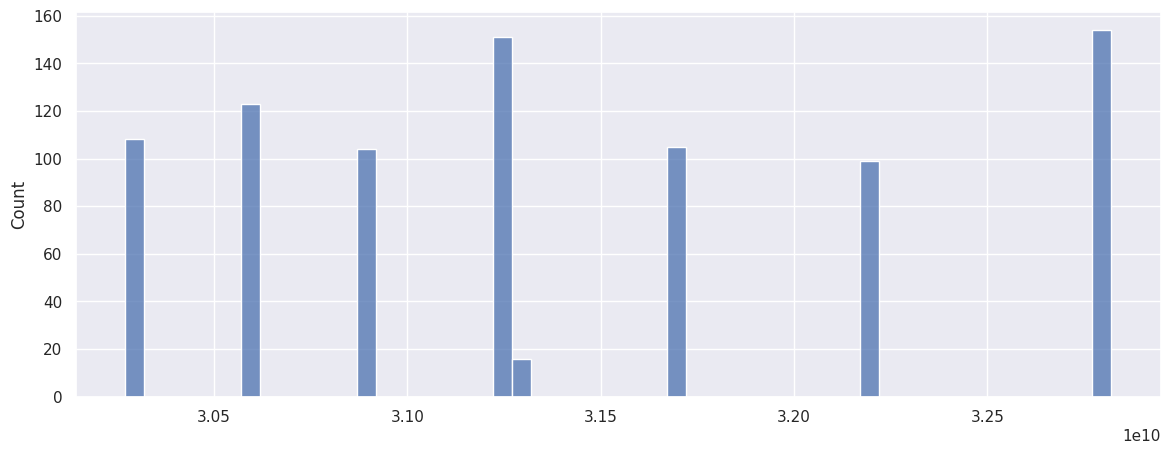

In [25]:
# Zoom in on the middle
# Note: The counts won't match the ones above because the bin width is different

# TODO How are you supposed to filter a series?
weirdos = misses[lambda id: id <= 3.75e10][lambda id: 3e10 <= id]

plt.figure(figsize=(14, 5))
sns.histplot(weirdos, binwidth=5e7)

In [26]:
# What portion of the requests we made actually returned something?
all = len(df) / (len(df) + len(misses))
# Same as above, but don't include requests for comments with IDs that were too low
exclude_invalid = len(df) / (len(df) + len(misses_actual))

all, exclude_invalid

(0.8475527426160337, 0.8475527426160337)

<Axes: xlabel='id', ylabel='rate'>

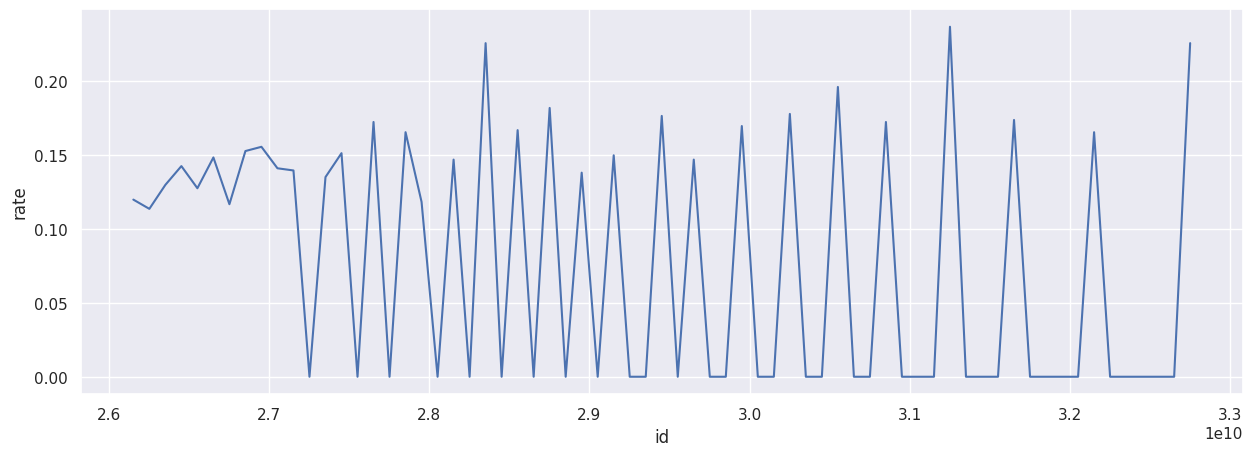

In [28]:
# Hit rate over time
start = first_id_actual
end = max(df.iloc[len(df) - 1][ID],
          misses.loc[len(misses) - 1])
step = int(1e8)

def get_rate(curr_id):
    next_id = curr_id + step
    hits = len(df[(curr_id <= df[ID]) & (df[ID] < next_id)])
    num_misses = len(misses[lambda id: curr_id <= id][lambda id: id < next_id])

    if num_misses == 0:
        return 0
    return num_misses / (hits + num_misses)

ids = np.arange(start, end, step)
rates = np.fromiter(map(get_rate, ids), dtype=np.dtype(np.float64))

rate_df = pd.DataFrame({ "id": ids, "rate": rates })

plt.figure(figsize=(15, 5))
sns.lineplot(data=rate_df, x="id", y="rate")

In [29]:
df[(3e10 <= df[ID]) & (df[ID] < 3.75e10)]

,id,time,sr_name,author_id,parent_fullname,post_id,upvotes,downvotes,body
16513,30001215087,2018-01-04 00:04:18,GlobalOffensiveTrade,15oc00,t1_ds4fj0q,t3_7ntstu,1,0,"hey /u/theblacketernity, you have been given a..."
16514,30269606656,2018-03-31 20:01:15,flashlight,9bmhp2z,t3_88ew49,t3_88ew49,1,0,"look into the maglite c-cell. maglite ml50l, t..."
16515,30269613992,2018-03-31 20:04:21,LosAngeles,10t0dn,t3_88m2br,t3_88m2br,2,0,vincenti in brentwood
16516,30269615608,2018-03-31 20:05:00,succulents,7iyw6,t3_88mrv2,t3_88mrv2,7,0,i have the same one! you’ll want to move the l...
16517,30269622522,2018-03-31 20:07:45,redsox,539fl,t1_dwlqy2j,t3_88kwgf,3,0,jesus christ.
...,...,...,...,...,...,...,...,...,...
20082,32819689542,2019-10-06 12:07:06,BoomBeach,NaN,t1_f2rzb3u,t3_ddjei6,2,0,just irritating that our task force owner work...
20083,32822239511,2019-10-06 17:03:06,Cardinals,6vl9o55,t3_de6zzz,t3_de6zzz,9,0,at least he took 3 more pitches than dejong...
20084,32822995485,2019-10-06 19:02:48,nfl,15gqsb,t1_f2txorq,t3_de8elz,2,0,"if ya'll shame the pats, i'm cool with a gulf ..."
20085,32824085316,2019-10-06 23:52:16,nfl,15l21j,t1_f2uldv8,t3_debhfs,1,0,"after the last season of mahomes? yeah, it is ..."


In [30]:
from scipy import stats

# Choose alpha of 0.05

misses_normalized = misses_actual.map(
    lambda id: (id - misses_actual.mean()) / (misses_actual.std())
)
res = stats.ks_1samp(misses_normalized, stats.norm.cdf)
if res.pvalue < 0.05:
    print("Misses are probably not normally distributed")
else:
    print("Misses could be normally distributed")
res

Misses are probably not normally distributed


KstestResult(statistic=0.12371698624408373, pvalue=1.1753280985896244e-48, statistic_location=-1.1566045254823731, statistic_sign=-1)

## Subreddits

In [31]:
df[df[SR_NAME] == "reddit.com"]

,id,time,sr_name,author_id,parent_fullname,post_id,upvotes,downvotes,body
72,26152075672,2010-01-05 18:28:04,reddit.com,1f0kz,t1_c0i9pzd,t3_alxuf,3,0,"my dog was pretty tough, i'm thinking he can f..."
88,26152155904,2010-01-06 15:07:54,reddit.com,39c3v,t3_amc7o,t3_amc7o,1,0,"can someone, anyone explain russell brand's se..."
100,26152206094,2010-01-07 02:19:21,reddit.com,359bi,t1_c0icjcp,t3_amkgy,8,0,yessss!
118,26152304024,2010-01-07 23:51:02,reddit.com,3e38s,t3_amzrt,t3_amzrt,9,0,lolwut?
130,26152403158,2010-01-08 23:24:12,reddit.com,obfm,t1_c0ig70f,t3_anaky,1,0,leno scheduled himself to retire and then rene...
...,...,...,...,...,...,...,...,...,...
3921,26285044822,2011-10-06 17:00:52,reddit.com,5duse,t1_c2pfmh8,t3_ku8ms,0,0,"so far, we haven't settled on a definition.\n\..."
3922,26285048899,2011-10-06 17:10:47,reddit.com,5n0u9,t1_c2pefn8,t3_l365s,6,0,a sistuh just fittin tah talk about the real o...
3927,26285078468,2011-10-06 18:24:30,reddit.com,40kcq,t1_c2pg8vj,t3_l3auo,57,0,[obligatory comment about how videos are block...
3952,26285196009,2011-10-06 23:55:41,reddit.com,4pczt,t3_l3s9i,t3_l3s9i,1,0,[i just created one](http://www.reddit.com/r/urm)


In [32]:
# Most popular subreddits
df[SR_NAME].value_counts().nlargest(20)

sr_name
AskReddit              2083
pics                    605
funny                   477
politics                377
gaming                  356
WTF                     260
reddit.com              256
leagueoflegends         211
worldnews               208
videos                  205
nba                     198
IAmA                    189
nfl                     183
atheism                 181
AdviceAnimals           177
todayilearned           168
CFB                     161
trees                   160
soccer                  131
fffffffuuuuuuuuuuuu     125
Name: count, dtype: int64